# RSA

## Setup

In [93]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import combinations
from src import stats, plotting, temporal, decoding, rsa

pd.set_option('display.max_rows', None)

In [96]:
subj = 'subj008'
process = 'EEG_RSA'
regress_gaze = True
run_pairwise = False
run_repetition_reliability = False
run_splithalf_reliability = True
run_fmri_rsa = True
run_sample_test = False
run_eye_regression = False

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
data_dir = f'{top_path}/data/'
figure_dir = f'{top_path}/reports/figures/{process}'

Path(figure_dir).mkdir(exist_ok=True, parents=True)
Path(f'{data_dir}/interim/{process}').mkdir(exist_ok=True, parents=True)

In [97]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [101]:
df = pd.read_csv(f'{data_dir}/interim/PreprocessData/{subj}_reg-gaze-{regress_gaze}.csv.gz')
feature_rdms = pd.read_csv(f'{data_dir}/interim/FeatureRDMs/feature_rdms.csv')

In [102]:
all_cols = set(df.columns.to_list())
other_cols = set(['trial', 'time', 'offset', 'offset_eyetrack_x', 'video_name',
              'gaze_x', 'gaze_y', 'pupil_size', 'target_x', 'target_y',
               'target_distance', 'offset_eyetrack_y', 'repetition', 'even'])
channels = list(all_cols - other_cols)

## Data Quality Check

### Reliability

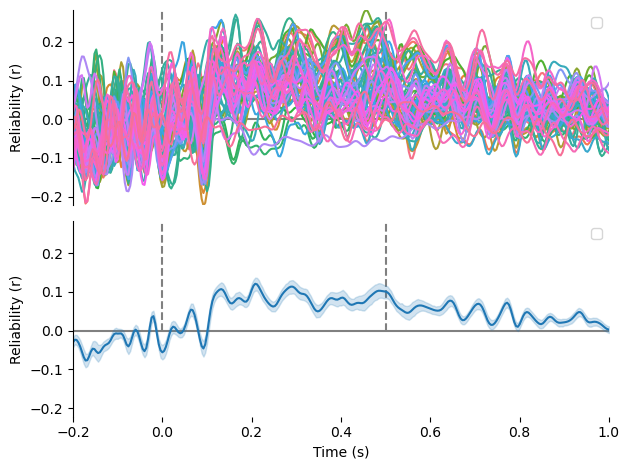

In [100]:
if run_splithalf_reliability:
    df_split = df.groupby(['time', 'video_name', 'even']).mean().reset_index()
    results = []
    time_groups = df_split.groupby('time')
    for time, time_df in time_groups:
        even = time_df[time_df.even].sort_values('video_name')
        odd = time_df[~time_df.even].sort_values('video_name')
        rs = stats.corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
        results.append([time,] + list(rs))
    results = pd.DataFrame(results, columns=['time',] + channels)
    results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

    plotting.plot_splithalf_reliability(results, f'{figure_dir}/{subj}_reliability_reg-gaze-{regress_gaze}.png')

## EEG RDMs

### Pairwise decoding

In [ ]:
df_filtered.sort_values(['time', 'video_name'], inplace=True)
videos = df_filtered.video_name.unique()
videos_nCk = list(combinations(videos, 2))
out_file = f'{out_path}/{subj}_decoding-distance.csv'

if run_pairwise:
    results = rsa.eeg_decoding_distance(df_filtered, channels, videos_nCk, n_groups)
    results.to_csv(out_file, index=False)
elif not run_pairwise and os.path.exists(out_file):
    results = pd.read_csv(out_file)
else:
    results = None

In [ ]:
if results is not None:
    plotting.plot_pairwise_decoding(results, f'{figure_path}/{subj}_decoding-distance.png')

Put the results in a dictionary for easy looping through different metrics

In [ ]:
eeg_rdms = dict()
eeg_rdms['decoding'] = results

### Correlation distance

In [ ]:
out_file = f'{out_path}/{subj}_correlation-distance.csv'
if os.path.exists(out_file):
    results = pd.read_csv(out_file)
else: 
    df_avg = df_filtered.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
    df_avg.drop(columns=['trial', 'repetition', 'even'], inplace=True)
    df_avg.sort_values(['time', 'video_name'], inplace=True)
    videos = df_avg.video_name.unique()
    videos_nCk = list(combinations(videos, 2))
    nCk = list(combinations(range(len(videos)), 2))

    results = rsa.eeg_coorelation_distance():

    results.to_csv(out_file, index=False)

Put the results in a dictionary for easy looping through different metrics

In [ ]:
eeg_rdms['correlation'] = results

### Smooth RDMs

In [ ]:
for EEG_metric in ['correlation', 'decoding']:
    if (EEG_metric in eeg_rdms.keys()) and (eeg_rdms[EEG_metric] is not None):
        eeg_rdms[EEG_metric] = temporal.smoothing(eeg_rdms[EEG_metric])

## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

,video_name,indoor,expanse,object_directedness,agent_distance,facingness,joint_action,communication,valence,arousal,...,alexnet_PC13,alexnet_PC14,alexnet_PC15,alexnet_PC16,alexnet_PC17,alexnet_PC18,alexnet_PC19,moten_PC0,moten_PC1,moten_PC2
0,-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700000,0.550,0.650000,0.340909,...,-1.082823,10.191237,-22.614979,20.582584,20.926926,19.438461,14.355835,7.659730,21.567951,4.739616
1,1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825000,0.900,0.675000,0.340909,...,258.609620,-38.368233,-33.512670,58.147423,40.795100,-20.262676,-65.375340,-14.666296,-13.239152,3.911069
2,2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575000,0.500,0.675000,0.075000,...,30.271772,17.192259,-6.165896,4.899196,-7.362109,51.271584,2.212805,5.335573,3.574568,4.336222
3,3PJaYWt0cws_5.mp4,0,0.625,1.000000,0.725000,0.340909,0.022727,0.150,0.600000,0.400000,...,-0.361651,13.382875,18.030890,12.732855,2.805191,5.295271,7.270865,-8.642924,11.198228,-8.109102
4,7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750000,0.825,0.722222,0.125000,...,62.311256,10.069392,50.194890,-33.658016,-59.276447,-21.671180,58.144630,-10.635544,-2.401499,2.511829


In [81]:
feature_rdms = rsa.feature_euclidean_distance(feature_df, feature_order)

NameError: name 'rsa' is not defined

## RSA

### EEG - Feature RSA

In [ ]:
for EEG_metric in ['correlation', 'decoding']:
    if (EEG_metric in eeg_rdms.keys()) and (eeg_rdms[EEG_metric] is not None):
        # filtered_eeg_rdms = filter_pairs(eeg_rdms[EEG_metric], video_set)
        # valid_videos = np.unique(np.concatenate([filtered_eeg_rdms.video1.to_numpy(),
        #                                           filtered_eeg_rdms.video2.to_numpy()]))
        # filtered_feature_rdms = filter_pairs(feature_rdms, valid_videos)

        out_file = f'{out_path}/{subj}_feature_EEG-{EEG_metric}_rsa.csv'
        results = rsa.compute_feature_eeg_rsa(feature_rdms, eeg_rdms[EEG_metric], out_file)
        results.to_csv(out_file, index=False)

        out_figure = f'{figure_path}/{subj}_feature_EEG-{EEG_metric}_rsa.png'
        plotting.plot_eeg_feature_rsa(results, feature_order, out_figure)

### EEG - fMRI RSA

In [ ]:
def load_fMRI_RDMs(files):
    fmri_rdms = []
    for file in files:
        fr = pd.read_csv(file)
        fmri_subj_name = file.split('/')[-1].split('_')[0]
        fr['subj'] = fmri_subj_name
        fmri_rdms.append(fr)
    fmri_rdms = pd.concat(fmri_rdms)
    fmri_rdms = fmri_rdms.groupby(['roi', 'video1', 'video2']).mean(numeric_only=True).reset_index()
    fmri_rdms.sort_values(by=['roi', 'video1', 'video2'])
    return fmri_rdms

In [ ]:
if run_fmri_rsa:
    for fMRI_metric in ['correlation', 'decoding']:
        files = glob(f'{fMRI_path}/*set-test*{fMRI_metric}-distance.csv')
        fmri_rdms = load_fMRI_RDMs(files)
        fmri_videos = np.unique(np.concatenate([fmri_rdms.video1.to_numpy(),
                                    fmri_rdms.video2.to_numpy()]))

        for EEG_metric in ['correlation', 'decoding']:
            if eeg_rdms[EEG_metric] is not None:
                filtered_eeg_rdms = rsa.filter_pairs(eeg_rdms[EEG_metric], fmri_videos)
                valid_videos = np.unique(np.concatenate([filtered_eeg_rdms.video1.to_numpy(),
                                                    filtered_eeg_rdms.video2.to_numpy()]))
                filtered_fmri_rdms = rsa.filter_pairs(fmri_rdms, valid_videos)

                out_file = f'{out_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.csv'
                results = rsa.compute_eeg_fmri_rsa(filtered_fmri_rdms, filtered_eeg_rdms, rois)
                results.to_csv(out_file, index=False)

                out_figure = f'{figure_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.png'
                plotting.plot_eeg_fmri_rsa(results, out_figure)


## Decoding

In [80]:
annot_feature_df = feature_df[['video_name',] + annotated_features]
videos = np.array(feature_df['video_name'])

df_avg = df_filtered.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
df_avg.drop(columns=['trial', 'repetition', 'even'], inplace=True)
df_avg.sort_values(['time', 'video_name'], inplace=True)
df_avg = temporal.smoothing(df_avg, 'video_name')

results = decoding.eeg_feature_decoding(df_avg, annot_feature_df,
                                    annotated_features, channels)
results.to_csv(f'{out_path}/{subj}_feature_EEG_decoding.csv', index=False)

out_file = f'{figure_path}/{subj}_feature_EEG_decoding.png'
plotting.plot_eeg_feature_decoding(out_file, results, annotated_features)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24223/3011165537.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video_name'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24223/1015294435.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
